In [1]:
from IPython.display import FileLink

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(dplyr); library(tidyr)
library(ggplot2)
library(phyloseq)
library(RColorBrewer)
library(gridExtra)
library(DESeq2)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.uns

###These files are from the [assign taxonomy](./Assign_taxonomy.ipynb), [tree](./Tree.ipynb), and [merge mappers](./demultiplex_QC/Merge_mappers.ipynb) notebooks.

In [4]:
%%R
#asNumeric = function(x) { as.numeric(as.character(x)) }

physeq = import_biom("/var/seq_data/priming_exp/data/otu_table_wtax.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)

head(physeq.md)

Sample Data:        [6 samples by 13 sample variables]:
                           Sample FractionNum Bulk Control CC X100 X700 H2O Day
12C.700.45.01.24 12C.700.45.01.24          24    0       1  0    0    1   0  45
12C.700.14.06.14 12C.700.14.06.14          14    0       1  0    0    1   0  14
12C.100.14.05.18 12C.100.14.05.18          18    0       1  0    1    0   0  14
12C.700.14.06.05 12C.700.14.06.05           5    0       1  0    0    1   0  14
12C.000.14.05.18 12C.000.14.05.18          18    0       1  1    0    0   0  14
12C.100.14.05.11 12C.100.14.05.11          11    0       1  0    1    0   0  14
                 Density rep contolVlabel Treatment
12C.700.45.01.24  1.6783          control    12C700
12C.700.14.06.14  1.7122          control    12C700
12C.100.14.05.18  1.6980          control    12C100
12C.700.14.06.05  1.7559          control    12C700
12C.000.14.05.18  1.6936          control    12C000
12C.100.14.05.11  1.7253          control    12C100


In [5]:
%%R
#physeq.bulk = prune_samples((physeq.md$Treatment %in% c("12C100","13C100","12C700","13C700", "13CC", "12CC")) &
physeq.bulk.100 = prune_samples((physeq.md$Treatment %in% c("12C100","13C100")) &
                            (physeq.md$Bulk == "1"),
                            physeq) 

physeq.bulk.100 = filter_taxa(physeq.bulk.100, function(x) sum(x) > 0, prune = TRUE)

physeq.bulk.100

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6390 taxa and 19 samples ]
sample_data() Sample Data:       [ 19 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 6390 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6390 tips and 6389 internal nodes ]


In [6]:
%%R
colnames(sample_data(physeq.bulk.100))

 [1] "Sample"       "FractionNum"  "Bulk"         "Control"      "CC"          
 [6] "X100"         "X700"         "H2O"          "Day"          "Density"     
[11] "rep"          "contolVlabel" "Treatment"   


In [7]:
%%R
dds = phyloseq_to_deseq2(physeq.bulk.100, ~Day)
dds = DESeq(dds, fitType = "local")

r = results(dds, cooksCutoff = FALSE)
r$OTU = rownames(r)
r = data.frame(r)

TT = data.frame(tax_table(physeq.bulk.100))
TT$OTU = rownames(TT)

r = left_join(r, TT)

converting counts to integer mode
the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 19 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Joining by: "OTU"


In [8]:
%%R
l2fc.time.100 = r %>% 
    filter(baseMean > 0)

write.csv(l2fc.time.100, "data/l2fc.100_Wtime_table.csv", row.names = FALSE)

In [9]:
!head data/l2fc.100_Wtime_table.csv | cut -c 1-60

"baseMean","log2FoldChange","lfcSE","stat","pvalue","padj","
0.0227990367583236,-0.00169926200368045,0.00682879494559363,
0.0647067849792222,-0.00272037800960609,0.0078081987150005,-
0.0227990367583236,-0.00169926200368045,0.00682879494559363,
0.0694968217226403,-0.0108111191755704,0.00805948398036255,-
38.408045333864,-0.00193369220011302,0.00626991815254338,-0.
18.3196073569794,-0.000794911719210677,0.0065563258338462,-0
3.33199272318697,-0.00843075465334567,0.0115527193633763,-0.
4.96614553181585,-0.000418356837604584,0.00925842253761836,-
94.443303871578,0.00446850338736171,0.00428714395223891,1.04


In [10]:
%%R
FDR = 0.10 

d = r %>%
    arrange(desc(abs(log2FoldChange))) %>%
    select(OTU, Rank2, Rank3, Rank4, log2FoldChange, padj) %>%
    filter(padj <= FDR)

head(d)

       OTU          Rank2               Rank3                Rank4
1  OTU.321 Proteobacteria Gammaproteobacteria        Legionellales
2  OTU.348 Proteobacteria Gammaproteobacteria        Legionellales
3  OTU.336  Bacteroidetes       Flavobacteria     Flavobacteriales
4 OTU.1171  Bacteroidetes       Flavobacteria     Flavobacteriales
5 OTU.1299 Proteobacteria                TA18 uncultured_bacterium
6  OTU.927 Proteobacteria Deltaproteobacteria         Myxococcales
  log2FoldChange         padj
1     0.07846548 1.496176e-08
2     0.07781155 6.474679e-07
3    -0.07464571 1.544844e-06
4    -0.06996904 3.820408e-07
5     0.06980883 1.040805e-05
6     0.06835911 6.474679e-07


###This file is from the [Sparsity Notebook](./Sparsity_make_l2fc_table.ipynb)

In [11]:
%%R
df.rspnse = read.csv("/var/seq_data/priming_exp/data/l2fc_table.csv")
head(df.rspnse)

  sparsity_threshold Day Treatment       OTU log2FoldChange         p    Rank1
1               0.25  14    13C000  OTU.4204    -0.20553170 1.0000000 Bacteria
2               0.25  14    13C000   OTU.467    -0.33054855 1.0000000 Bacteria
3               0.25  14    13C000   OTU.905     0.01698885 0.9827594 Bacteria
4               0.25  14    13C000  OTU.7253     0.02799601 0.9772968 Bacteria
5               0.25  14    13C000    OTU.67    -0.60115954 1.0000000 Bacteria
6               0.25  14    13C000 OTU.10580     0.36193427 0.7248674 Bacteria
          Rank2 Rank3                Rank4 Rank5 Rank6 Rank7 Rank8 padj
1 Acidobacteria DA023                 <NA>  <NA>  <NA>  <NA>  <NA>    1
2 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
3 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
4 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
5 Acidobacteria DA023 uncultured_bacterium  <NA>  <NA>  <NA>  <NA>    1
6 Acidobacteria

In [12]:
%%R
FDR = 0.10

resp.100 = df.rspnse %>% 
    filter((padj <= FDR),
           (Treatment == "13C100")) 

resp.100$rspnse = as.character("RE - Continuous")
resp.100 = resp.100 %>%
    select(OTU, rspnse)
head(resp.100)

       OTU          rspnse
1 OTU.5545 RE - Continuous
2  OTU.752 RE - Continuous
3  OTU.473 RE - Continuous
4 OTU.7576 RE - Continuous
5 OTU.1248 RE - Continuous
6  OTU.277 RE - Continuous


In [13]:
%%R
d = left_join(d, resp.100, by = "OTU")

#d$Treatment = as.character("RE - continuous")
#d = d %>%
#    select(OTU, Rank2, Rank3, Rank4, log2FoldChange, padj, Treatment, rspnse)
d$rspnse[is.na(d$rspnse)] = "None"
#levels(d$rspnse) = c("Xylose", "Cellulose", "Both", "None")
head(d)

       OTU          Rank2               Rank3                Rank4
1  OTU.321 Proteobacteria Gammaproteobacteria        Legionellales
2  OTU.348 Proteobacteria Gammaproteobacteria        Legionellales
3  OTU.336  Bacteroidetes       Flavobacteria     Flavobacteriales
4 OTU.1171  Bacteroidetes       Flavobacteria     Flavobacteriales
5 OTU.1299 Proteobacteria                TA18 uncultured_bacterium
6  OTU.927 Proteobacteria Deltaproteobacteria         Myxococcales
  log2FoldChange         padj          rspnse
1     0.07846548 1.496176e-08            None
2     0.07781155 6.474679e-07            None
3    -0.07464571 1.544844e-06 RE - Continuous
4    -0.06996904 3.820408e-07            None
5     0.06980883 1.040805e-05            None
6     0.06835911 6.474679e-07            None


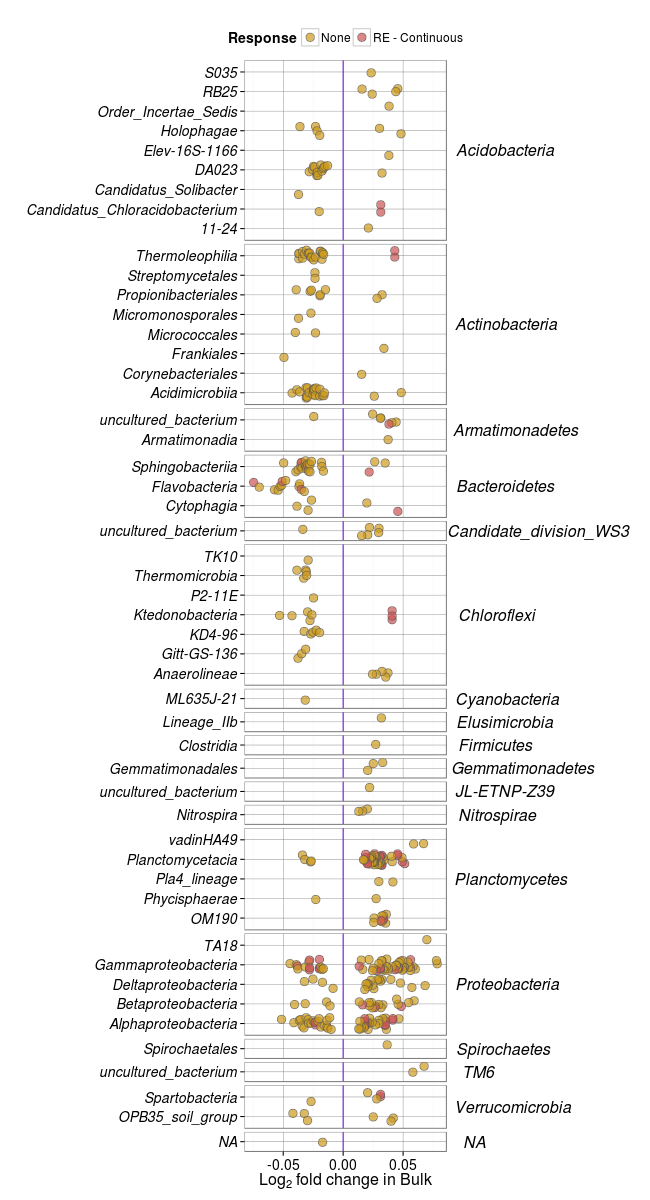

In [14]:
%%R -h 1200 -w 650

colours = c("goldenrod3", "indianred3", "#3050C1")
#getPalette = colorRampPalette(brewer.pal(3, "Dark2"))

p = ggplot(d, aes(y = Rank3, x = log2FoldChange, fill = rspnse))

p = p + geom_point(size = 4, shape = 21, alpha = 0.7, position = position_jitter(h = 0.3, w = 0), color = "gray33")

p = p + facet_grid(Rank2 ~ ., scales = "free_y", space = "free")

p = p + geom_vline(xintercept = 0, color = "#751BEA")

p = p + scale_fill_manual(values=colours, na.value = "black")

p = p + theme_bw()

p = p + labs(x = expression(paste(Log[2]," fold change in Bulk",sep="")), y = " ", fill = "Response")

p = p + theme(axis.text.y = element_text(size = 14, face = "italic"),
              axis.text.x = element_text(size = 14), 
              axis.title = element_text(size = 16),
              strip.text.y = element_text(angle = 0, hjust = 0.1, size = 16, face = "italic"),
              strip.background = element_blank(),
              panel.grid.major = element_line(colour = "#808080"),
              legend.position = "top",
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p

In [15]:
%%R
#physeq.bulk = prune_samples((physeq.md$Treatment %in% c("12C100","13C100","12C700","13C700", "13CC", "12CC")) &
physeq.bulk.700 = prune_samples((physeq.md$Treatment %in% c("12C700","13C700")) &
                            (physeq.md$Bulk == "1"),
                            physeq) 

physeq.bulk.700 = filter_taxa(physeq.bulk.700, function(x) sum(x) > 0, prune = TRUE)

physeq.bulk.700

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6052 taxa and 19 samples ]
sample_data() Sample Data:       [ 19 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 6052 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6052 tips and 6051 internal nodes ]


In [16]:
%%R
dds2 = phyloseq_to_deseq2(physeq.bulk.700, ~Day)
dds2 = DESeq(dds2, fitType = "local")

r2 = results(dds2, cooksCutoff = FALSE)
r2$OTU = rownames(r2)
r2 = data.frame(r2)

TT2 = data.frame(tax_table(physeq.bulk.700))
TT2$OTU = rownames(TT2)

r2 = left_join(r2, TT2)

converting counts to integer mode
the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 27 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Joining by: "OTU"


In [17]:
%%R
l2fc.time.700 = r2 %>% 
    filter(baseMean > 0)

write.csv(l2fc.time.700, "data/l2fc.700_Wtime_table.csv", row.names = FALSE)

In [18]:
!head data/l2fc.700_Wtime_table.csv | cut -c 1-60

"baseMean","log2FoldChange","lfcSE","stat","pvalue","padj","
0.0807998766533975,0.000925763313062286,0.00638097058805417,
0.0219293240759275,-0.00282024129744472,0.00603128479307853,
0.0807998766533975,0.000925763313062286,0.00638097058805417,
0.097214350931759,-0.00616635568961508,0.00689053137056699,-
0.0219293240759275,-0.00282024129744472,0.00603128479307853,
32.7902906179436,-0.00923611504300747,0.0073300324749052,-1.
16.8764280087137,-0.0146177335680454,0.00750527601723599,-1.
1.9120965924233,-0.0347918634110403,0.0124161790660652,-2.80
3.65328878737022,-0.0383651672760093,0.0110645056284391,-3.4


In [19]:
%%R
FDR = 0.10 

d2 = r2 %>%
    arrange(desc(abs(log2FoldChange))) %>%
    select(OTU, Rank2, Rank3, Rank4, log2FoldChange, padj) %>%
    filter(padj <= FDR)

nrow(d2)

[1] 230


In [20]:
%%R
FDR = 0.10

resp.700 = df.rspnse %>% 
    filter((padj <= FDR),
           (Treatment == "13C700")) 

resp.700$rspnse = as.character("RE - Pulse")
resp.700 = resp.700 %>%
    select(OTU, rspnse)

nrow(resp.700)

[1] 524


In [21]:
%%R
d2 = left_join(d2, resp.700, by = "OTU")
#d2$Treatment = as.character("RE - single")

d2$rspnse[is.na(d2$rspnse)] = "None"
#levels(d$rspnse) = c("Xylose", "Cellulose", "Both", "None")
#d2 = d2 %>%
#    select(OTU, Rank2, Rank3, Rank4, log2FoldChange, padj, rspnse)
head(d2)

       OTU          Rank2                Rank3           Rank4 log2FoldChange
1  OTU.474 Proteobacteria  Gammaproteobacteria Pseudomonadales    -0.09390819
2 OTU.1343 Proteobacteria  Gammaproteobacteria Pseudomonadales    -0.07140600
3  OTU.584 Proteobacteria  Gammaproteobacteria   Legionellales     0.07008438
4  OTU.452            TM6 uncultured_bacterium            <NA>     0.06641945
5  OTU.433 Proteobacteria  Gammaproteobacteria            NKB5     0.06336675
6  OTU.433 Proteobacteria  Gammaproteobacteria            NKB5     0.06336675
          padj     rspnse
1 2.398608e-11       None
2 9.401499e-06       None
3 9.401499e-06 RE - Pulse
4 6.079028e-05       None
5 1.636486e-04 RE - Pulse
6 1.636486e-04 RE - Pulse


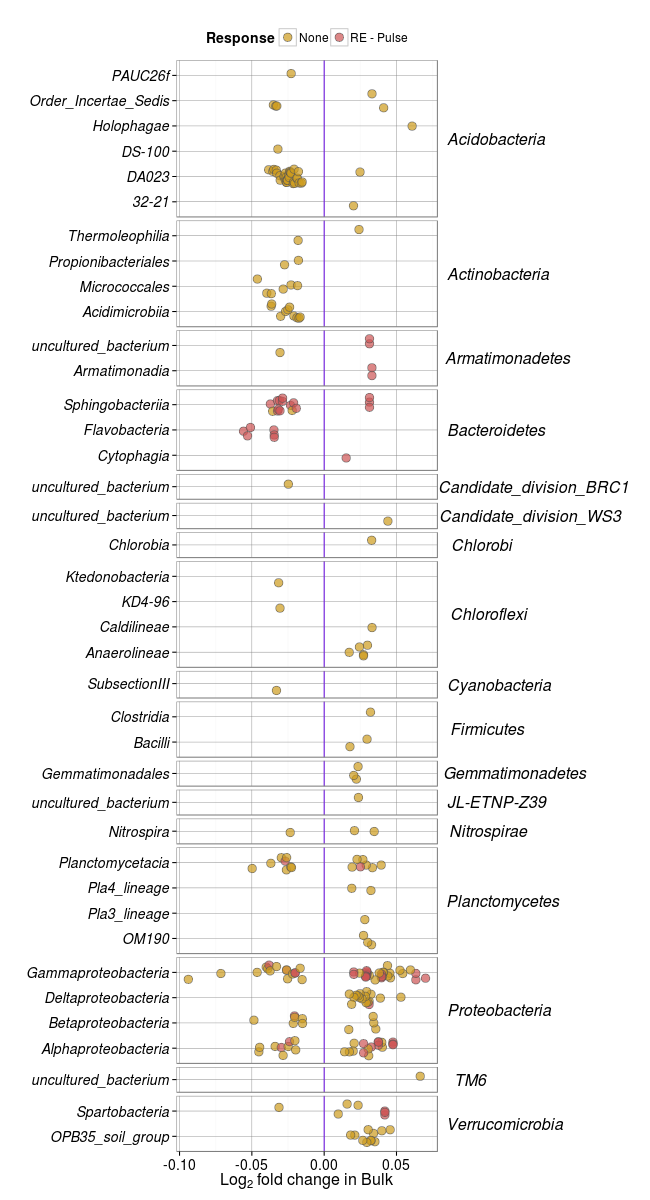

In [22]:
%%R -h 1200 -w 650

colours = c("goldenrod3", "indianred3", "#3050C1")
#getPalette = colorRampPalette(brewer.pal(3, "Dark2"))

p2 = ggplot(d2, aes(y = Rank3, x = log2FoldChange, fill = rspnse))

p2 = p2 + geom_point(size = 4, shape = 21, alpha = 0.7, position = position_jitter(h = 0.3, w = 0), color = "gray33")

p2 = p2 + facet_grid(Rank2 ~ ., scales = "free_y", space = "free")

p2 = p2 + geom_vline(xintercept = 0, color = "#751BEA")

p2 = p2 + scale_fill_manual(values=colours, na.value = "black")

p2 = p2 + theme_bw()

p2 = p2 + labs(x = expression(paste(Log[2]," fold change in Bulk",sep="")), y = " ", fill = "Response")

p2 = p2 + theme(axis.text.y = element_text(size = 14, face = "italic"),
              axis.text.x = element_text(size = 14), 
              axis.title = element_text(size = 16),
              strip.text.y = element_text(angle = 0, hjust = 0.1, size = 16, face = "italic"),
              strip.background = element_blank(),
              panel.grid.major = element_line(colour = "#808080"),
              legend.position = "top",
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p2

In [23]:
%%R
#physeq.bulk = prune_samples((physeq.md$Treatment %in% c("12C100","13C100","12C700","13C700", "13CC", "12CC")) &
physeq.bulk.CC = prune_samples((physeq.md$Treatment %in% c("12C000","13C000")) &
                            (physeq.md$Bulk == "1"),
                            physeq) 

physeq.bulk.CC = filter_taxa(physeq.bulk.CC, function(x) sum(x) > 0, prune = TRUE)

physeq.bulk.CC

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6008 taxa and 19 samples ]
sample_data() Sample Data:       [ 19 samples by 13 sample variables ]
tax_table()   Taxonomy Table:    [ 6008 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6008 tips and 6007 internal nodes ]


In [24]:
%%R
dds3 = phyloseq_to_deseq2(physeq.bulk.CC, ~Day)
dds3 = DESeq(dds3, fitType = "local")

r3 = results(dds3, cooksCutoff = FALSE)
r3$OTU = rownames(r3)
r3 = data.frame(r3)

TT3 = data.frame(tax_table(physeq.bulk.CC))
TT3$OTU = rownames(TT3)

r3 = left_join(r3, TT3)

converting counts to integer mode
the design formula contains a numeric variable with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 8 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
Joining by: "OTU"


In [25]:
%%R
l2fc.time.CC = r3 %>% 
    filter(baseMean > 0)

write.csv(l2fc.time.CC, "data/l2fc.CC_Wtime_table.csv", row.names = FALSE)

In [26]:
!head data/l2fc.CC_Wtime_table.csv | cut -c 1-60

"baseMean","log2FoldChange","lfcSE","stat","pvalue","padj","
0.0579027020406244,4.47915862249382e-05,0.00369476102967312,
0.0429320130869977,-0.00262138980531693,0.0036951303219747,-
0.0723840900849091,0.00283456925470182,0.00372794613029707,0
0.0829138538403759,0.00300110836569467,0.003741484842152,0.8
0.0561084762724833,-0.0018484885066136,0.00370689607925407,-
0.101142272651486,-0.00115118464555346,0.00373740890108131,-
0.0280542381362416,-0.00120611853429416,0.00369429301459633,
35.3443494892491,-0.018431253049369,0.00641423090176481,-2.8
15.5534836166911,-0.00957003889646009,0.00663767785360096,-1


In [27]:
%%R
FDR = 0.10 

d3 = r3 %>%
    arrange(desc(abs(log2FoldChange))) %>%
    select(OTU, Rank2, Rank3, Rank4, log2FoldChange, padj) %>%
    filter(padj <= FDR)

nrow(d3)

[1] 176


In [28]:
%%R
FDR = 0.10

resp.CC = df.rspnse %>% 
    filter((padj <= FDR),
           (Treatment == "13C000")) 

resp.CC$rspnse = as.character("Cellulose Only")
resp.CC = resp.CC %>%
    select(OTU, rspnse)

nrow(resp.CC)

[1] 533


In [29]:
%%R
d3 = left_join(d3, resp.CC, by = "OTU")
#d2$Treatment = as.character("RE - single")

d3$rspnse[is.na(d3$rspnse)] = "None"
#levels(d$rspnse) = c("Xylose", "Cellulose", "Both", "None")
#d2 = d2 %>%
#    select(OTU, Rank2, Rank3, Rank4, log2FoldChange, padj, rspnse)
head(d3)

       OTU          Rank2               Rank3            Rank4 log2FoldChange
1  OTU.318 Proteobacteria Gammaproteobacteria    Legionellales     0.07490696
2  OTU.321 Proteobacteria Gammaproteobacteria    Legionellales     0.05117563
3 OTU.1419  Bacteroidetes       Flavobacteria Flavobacteriales    -0.04431675
4 OTU.1419  Bacteroidetes       Flavobacteria Flavobacteriales    -0.04431675
5  OTU.927 Proteobacteria Deltaproteobacteria     Myxococcales     0.04406985
6  OTU.653 Proteobacteria Deltaproteobacteria     Myxococcales     0.04302321
          padj         rspnse
1 2.533980e-15           None
2 6.969310e-05           None
3 6.588416e-04 Cellulose Only
4 6.588416e-04 Cellulose Only
5 7.596373e-04 Cellulose Only
6 1.296459e-04           None


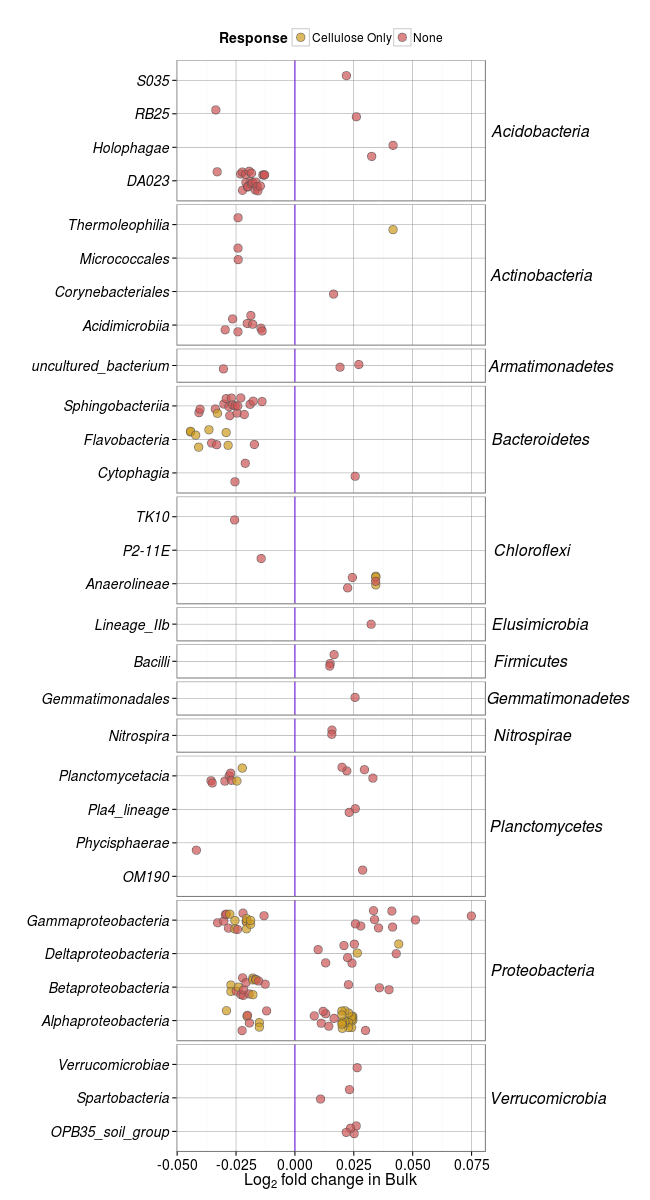

In [30]:
%%R -h 1200 -w 650

colours = c("goldenrod3", "indianred3", "#3050C1")
#getPalette = colorRampPalette(brewer.pal(3, "Dark2"))

p3 = ggplot(d3, aes(y = Rank3, x = log2FoldChange, fill = rspnse))

p3 = p3 + geom_point(size = 4, shape = 21, alpha = 0.7, position = position_jitter(h = 0.3, w = 0), color = "gray33")

p3 = p3 + facet_grid(Rank2 ~ ., scales = "free_y", space = "free")

p3 = p3 + geom_vline(xintercept = 0, color = "#751BEA")

p3 = p3 + scale_fill_manual(values=colours, na.value = "black")

p3 = p3 + theme_bw()

p3 = p3 + labs(x = expression(paste(Log[2]," fold change in Bulk",sep="")), y = " ", fill = "Response")

p3 = p3 + theme(axis.text.y = element_text(size = 14, face = "italic"),
              axis.text.x = element_text(size = 14), 
              axis.title = element_text(size = 16),
              strip.text.y = element_text(angle = 0, hjust = 0.1, size = 16, face = "italic"),
              strip.background = element_blank(),
              panel.grid.major = element_line(colour = "#808080"),
              legend.position = "top",
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p3

In [31]:
%%R
l2fc.time = rbind(d, d2, d3)
l2fc.time = l2fc.time %>%
    filter(rspnse %in% c("Cellulose Only", "RE - Pulse", "RE - Continuous"))
l2fc.time

          OTU           Rank2                          Rank3
1     OTU.336   Bacteroidetes                  Flavobacteria
2     OTU.109  Proteobacteria            Gammaproteobacteria
3     OTU.109  Proteobacteria            Gammaproteobacteria
4     OTU.238  Planctomycetes               Planctomycetacia
5     OTU.237   Bacteroidetes                  Flavobacteria
6    OTU.1650  Planctomycetes               Planctomycetacia
7     OTU.965  Proteobacteria             Betaproteobacteria
8    OTU.6983  Proteobacteria            Gammaproteobacteria
9    OTU.6983  Proteobacteria            Gammaproteobacteria
10    OTU.645   Bacteroidetes                     Cytophagia
11    OTU.701  Planctomycetes               Planctomycetacia
12    OTU.701  Planctomycetes               Planctomycetacia
13    OTU.144  Proteobacteria            Gammaproteobacteria
14    OTU.224  Actinobacteria                Thermoleophilia
15    OTU.224  Actinobacteria                Thermoleophilia
16    OTU.111  Proteobac

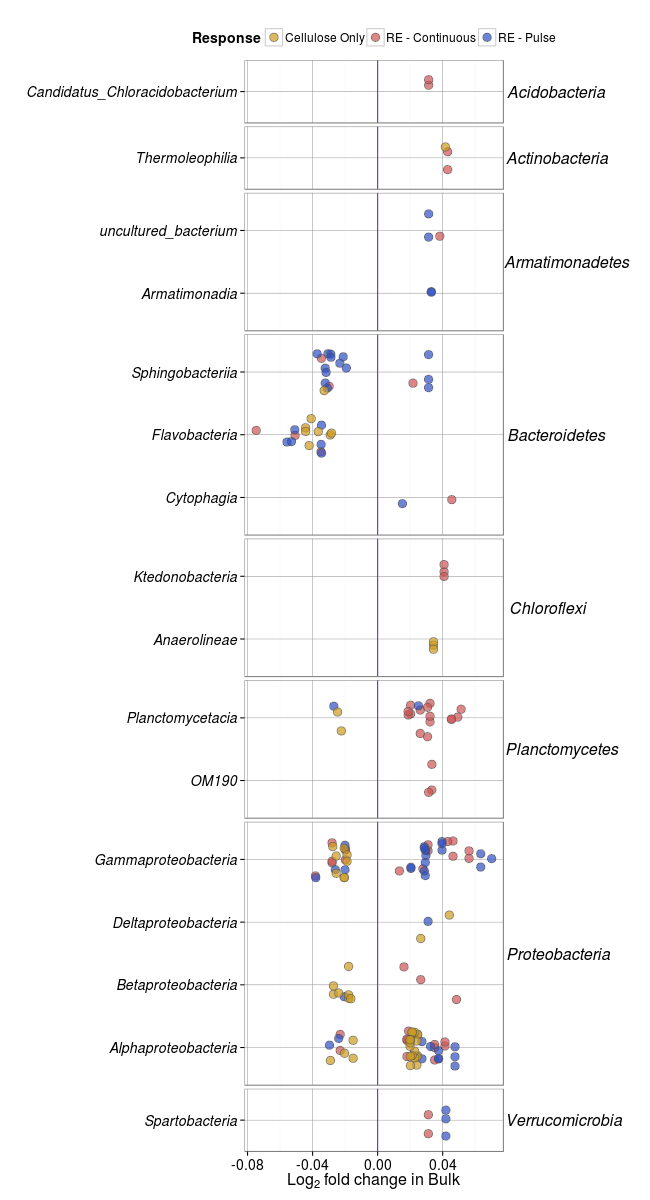

In [32]:
%%R -h 1200 -w 650

colours = c("goldenrod3", "indianred3", "#3050C1", "black")
#getPalette = colorRampPalette(brewer.pal(3, "Dark2"))

p4 = ggplot(l2fc.time, aes(y = Rank3, x = log2FoldChange, fill = rspnse))

p4 = p4 + geom_point(size = 4, shape = 21, alpha = 0.7, position = position_jitter(h = 0.3, w = 0), color = "gray33")

p4 = p4 + facet_grid(Rank2 ~ ., scales = "free_y", space = "free")

p4 = p4 + geom_vline(xintercept = 0, color = "#751BEA")

p4 = p4 + scale_fill_manual(values=colours, na.value = "black")

p4 = p4 + theme_bw()

p4 = p4 + labs(x = expression(paste(Log[2]," fold change in Bulk",sep="")), y = " ", fill = "Response")

p4 = p4 + theme(axis.text.y = element_text(size = 14, face = "italic"),
              axis.text.x = element_text(size = 14), 
              axis.title = element_text(size = 16),
              strip.text.y = element_text(angle = 0, hjust = 0.1, size = 16, face = "italic"),
              strip.background = element_blank(),
              panel.grid.major = element_line(colour = "#808080"),
              legend.position = "top",
              legend.title = element_text(size = 14),
              legend.text = element_text(size = 12))

p4

In [33]:
%%R
FDR = 0.10

df.rspnse.100 = df.rspnse %>%
    filter(Treatment == "13C100") %>%
    group_by(OTU, Treatment) %>%
    #summarize(min.P = min(padj), 
    #          Rank2 = first(Rank2), 
    #          Rank3 = first(Rank3)) %>%
    filter(padj <= FDR) %>%
    group_by(OTU) %>%
    #summarize(rspnse = rspnse(min.P, Treatment)) %>%
    left_join(df.bulk.100)

df.rspnse.100$Day = as.factor(df.rspnse.100$Day)
df.rspnse.100

Error in tbl_vars(y) : object 'df.bulk.100' not found
In addition: Warning messages:
1: joining factor and character vector, coercing into character vector 
2: joining factor and character vector, coercing into character vector 
3: joining factor and character vector, coercing into character vector
Error in tbl_vars(y) : object 'df.bulk.100' not found


NULL


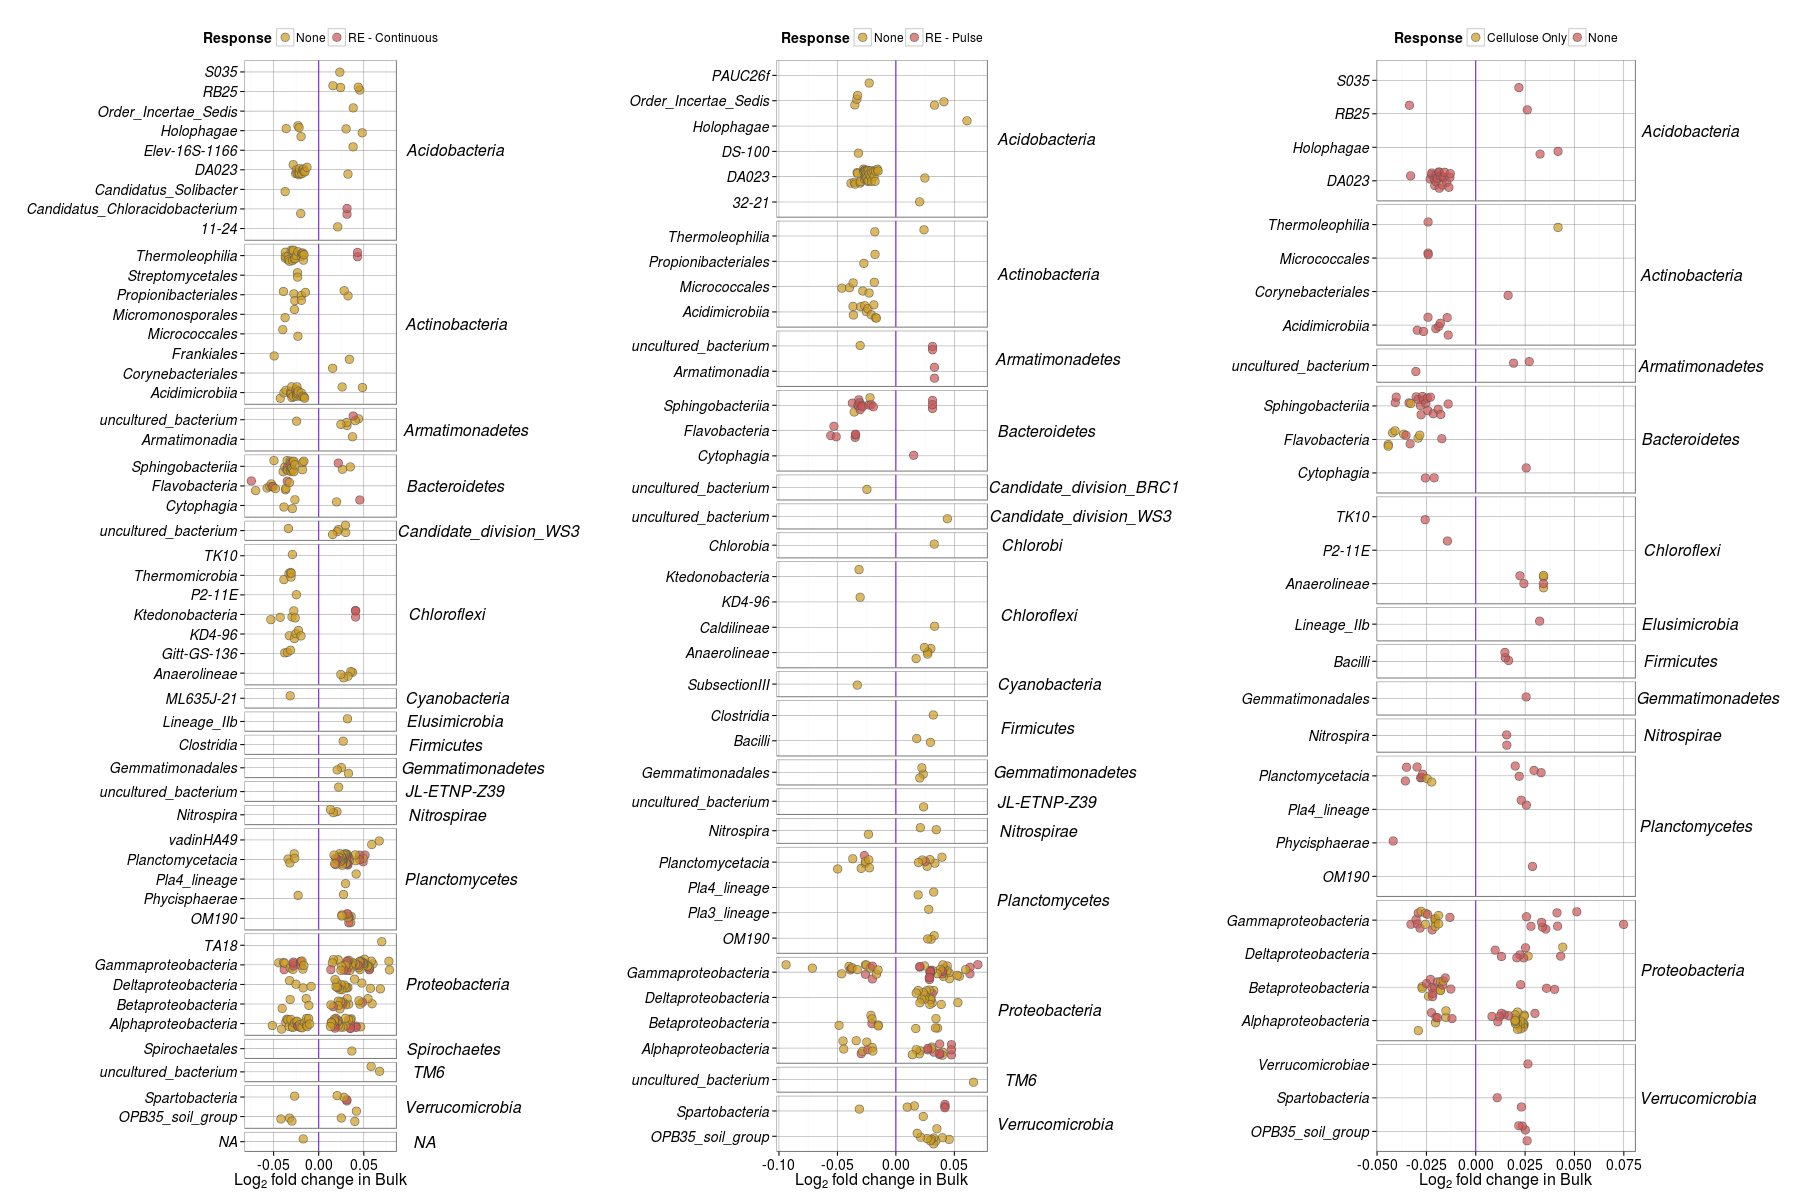

In [34]:
%%R -h 1200 -w 1800
p.combined = grid.arrange(p, p2, p3, ncol = 3)
p.combined

In [35]:
%%R -w 1000 -h 1200
pdf("figs/bulkl2fc_time.pdf", width = 25, height = 17)
grid.arrange(p, p2, p3, ncol=3)
dev.off()

png 
  2 


In [36]:
FileLink("figs/bulkl2fc_time.pdf")

/home/ashley/priming_exp/figs/bulkl2fc_time.pdf

In [39]:
%%R 
png("figs/bulkl2fc_time.png", width = 25, height = 17, units = "in", res = 600)
grid.arrange(p, p2, p3, ncol=3)
dev.off()

png 
  2 


In [40]:
FileLink("figs/bulkl2fc_time.png")

/home/ashley/priming_exp/figs/bulkl2fc_time.png